<a href="https://colab.research.google.com/github/stadanapisem/Sentiment-Analysis_SerbMR/blob/master/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cPickle as pickle
import numpy as np
from sklearn import metrics
from sklearn import naive_bayes
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import coo_matrix, hstack
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import gensim

from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Embedding, CuDNNGRU, LSTM, CuDNNLSTM, Flatten, Bidirectional, Dropout, Conv1D, MaxPool1D
from keras.initializers import Constant
from keras.utils import to_categorical
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf

import warnings

%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

# Data Loading

* Loading the preprocessed input data. Preprocessing was done before due to the difficulties of running the neccessary tools on this platform. It consisted of a tokeniser and a lemmantiser.
* Loading the sentiment lexicon


In [3]:
!git clone https://github.com/stadanapisem/Sentiment-Analysis_SerbMR.git

Cloning into 'Sentiment-Analysis_SerbMR'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 5), reused 10 (delta 2), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [0]:
with open('Sentiment-Analysis_SerbMR/lemmantised_SerbMR-2C.p') as f:
  data2C = pickle.load(f)
  

In [0]:
with open('Sentiment-Analysis_SerbMR/lemmantised_SerbMR-3C.p') as f:
  data3C = pickle.load(f)

In [0]:
with open('Sentiment-Analysis_SerbMR/sr.lexicon') as f:
  lex = f.readlines()

lexicon = {}
for x in lex:
  x = x.split()
  lexicon[x[0].decode('utf8')] = int(x[1].strip())


#### Utilities

In [0]:
# from https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, normalize=True, figsize = (5,4), fontsize=14):
  """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

  Arguments
  ---------
  confusion_matrix: numpy.ndarray
      The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
      Similarly constructed ndarrays can also be used.
  class_names: list
      An ordered list of class names, in the order they index the given confusion matrix.
  figsize: tuple
      A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
      the second determining the vertical size. Defaults to (10,7).
  fontsize: int
      Font size for axes labels. Defaults to 14.

  Returns
  -------
  matplotlib.figure.Figure
      The resulting confusion matrix figure
  """
  if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
       
  df_cm = pd.DataFrame(
      confusion_matrix, index=class_names, columns=class_names, 
  )
  fig = plt.figure(figsize=figsize)
  fmt = '.2f' if normalize else 'd'
  try:
      heatmap = sns.heatmap(df_cm, annot=True, fmt=fmt)
  except ValueError:
      raise ValueError("Confusion matrix values must be integers.")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  fig.tight_layout()
  plt.show()

## Train / Validation / Test split


In [0]:
def do_double_split(data, split):
  examples = []
  labels = []
  
  for row in data:
      examples.append(u' '.join(row[0]))
      labels.append(row[1])

  return train_test_split(examples, labels, train_size=split, shuffle=True, stratify=labels)

def do_tri_split(data):
  X_train, X_test, y_train, y_test = do_double_split(data, 0.65)
  X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, train_size=0.5, shuffle=True, stratify=y_test)

  return {
      'Xtrain' : X_train,
      'ytrain' : y_train,
      'Xval' : X_validation,
      'yval' : y_validation,
      'Xtst' : X_test,
      'ytst' : y_test
  }

In [0]:
data_2_class = do_tri_split(data2C)
data_3_class = do_tri_split(data3C)

# Experiment 001
Solution based only on the sentiment lexicon. The model is based on one parameter: limit. The average polarity of each sample is calculated (essentially wheather there are more positive or negative words). The prediction only takes into consideration if the calculated average is grater than the limit or not.


#### 2 Class

('Training F1:', 0.5724907063197026)
('Model limit:', 0.07540000000000073)
Evaluation
0.5816023738872403
[[118  50]
 [ 91  78]]
0.5252525252525252


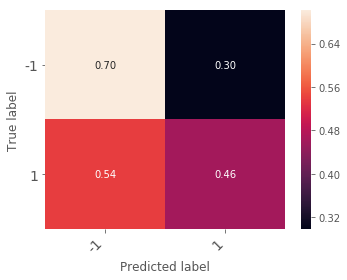

In [71]:
# LIMIT = 0.077

def run(data, LIMIT):
  results = []
  for row in data:
    words = row.split(' ')
    polarity = []
    for w in words:
      polarity.append(lexicon.get(w, 0))

    if np.mean(polarity) > LIMIT:
      results.append(1)
    else: results.append(-1)

  return results

data = do_double_split(data2C, 0.8)
# print(len(data[2]), len(data[0]))
max_acc = -1
res = -1

for LIMIT in np.arange(0.05, 0.1, 0.0002):
  results = run(data[0], LIMIT)
  acc = metrics.accuracy_score(data[2], results)

  if acc > max_acc:
    max_acc = acc
    res = LIMIT

print('Training accuracy:', max_acc)
print('Model limit:', res)

results = run(data[1], res)

print ('Evaluation')
print('Accuracy', metrics.accuracy_score(data[3], results))
# print(metrics.confusion_matrix(data[3], results))
print('F1 Score', metrics.f1_score(data[3], results))
  
print_confusion_matrix(metrics.confusion_matrix(data[3], results), ["-1", "1"])

#### 3 Class

('Training accuracy:', 0.3810703666997027)
('Model neg and pos limit:', 0.05800000000000002, 0.07800000000000001)
Evaluation
('Accuracy', 0.41188118811881186)


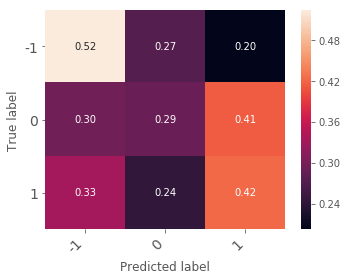

In [21]:
def run(data, posLIMIT, negLIMIT):
  results = []
  for row in data:
    words = row.split(' ')
    polarity = []
    for w in words:
      polarity.append(lexicon.get(w, 0))

    mean_pol = np.mean(polarity)
    if mean_pol >= posLIMIT:
      results.append(1)
    elif mean_pol <= negLIMIT: 
      results.append(-1)
    else:
      results.append(0)

  return results

# posLIMIT = 0.45
# negLIMIT = 0.05
data = do_double_split(data3C, 0.8)

max_acc = 0
res_min = -1
res_max = -1

for posLIMIT in np.arange(0.04, 0.15, 0.0005):
  for negLIMIT in np.arange(-0.1, 0.04, 0.005):
    results = run(data[0], posLIMIT, negLIMIT)

    acc = metrics.accuracy_score(data[2], results)
    
    if acc > max_acc:
      max_acc = acc
      res_min = negLIMIT
      res_max = posLIMIT
    
print('Training accuracy:', max_acc)
print('Model neg and pos limit:', res_min, res_max)
    
results = run(data[1], res_max, res_min)
    
print('Evaluation')
print('Accuracy', metrics.accuracy_score(data[3], results))
# print(metrics.confusion_matrix(data[3], results))
print_confusion_matrix(metrics.confusion_matrix(data[3], results), ["-1", "0", "1"])

# Experiment 002

Solution based only on the sentiment lexicon, however this time it takes into consideration the ratio of positive / negative and the total number of words in the example.

#### 2 Class

0.5


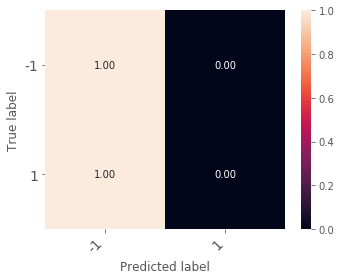

In [24]:
results = []
for row in data2C:
  words = row[0]
  polarity = []
  for w in words:
    polarity.append(lexicon.get(w, 0))
  
  counts = dict(zip(*np.unique(polarity, return_counts=True)))
#   print(counts)
  total_words = counts[-1] + counts[0] + counts[1]
  ratio_pos = counts[1] / total_words
  ratio_neg = counts[-1] / total_words
  
  if ratio_pos > ratio_neg:
    results.append(1)
  else: results.append(-1)
    
print(metrics.accuracy_score([x[1] for x in data2C], results))
# print(metrics.confusion_matrix([x[1] for x in data2C], results))
print_confusion_matrix(metrics.confusion_matrix([x[1] for x in data2C], results), ["-1", "1"])

#### 3 Class

0.3333333333333333


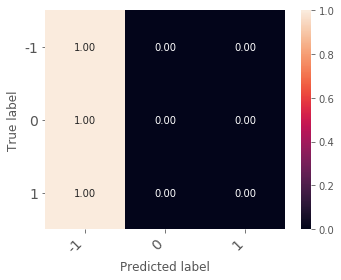

In [25]:
results = []
for row in data3C:
  words = row[0]
  polarity = []
  for w in words:
    polarity.append(lexicon.get(w, 0))
  
  counts = dict(zip(*np.unique(polarity, return_counts=True)))
#   print(counts)
  total_words = counts[-1] + counts[0] + counts[1]
  ratio_pos = counts[1] / total_words
  ratio_neg = counts[-1] / total_words
  
  if ratio_pos > ratio_neg:
    results.append(1)
  else: results.append(-1)
    
print(metrics.accuracy_score([x[1] for x in data3C], results))
# print(metrics.confusion_matrix([x[1] for x in data3C], results))
print_confusion_matrix(metrics.confusion_matrix([x[1] for x in data3C], results), ["-1", "0", "1"])

# Feature Extraction


In [0]:
def polarity_counts(data, posLIMIT, negLIMIT, skip = 1):
  words = data.split(' ')
  polarity = []
  for word in map(None, *(iter(words),) * skip):
    pol = []

    if skip == 1:
      word = [word]
      
    for w in word:
      if w:
        pol.append(lexicon.get(w, 0))
      else:
        break
    
    if np.mean(pol) >= posLIMIT:
      polarity.append(1)
    elif np.mean(pol) <= negLIMIT:
      polarity.append(-1)
    else:
      polarity.append(0)
  
  counts = dict(zip(*np.unique(polarity, return_counts=True)))
#   print(counts)
  return [counts.get(-1, 0), counts.get(0, 0), counts.get(1, 0)]

def create_feature_vector(data, posLIMIT, negLIMIT):
  features = []
  for example in data:
    features += [polarity_counts(example, posLIMIT, negLIMIT) + polarity_counts(example, posLIMIT, negLIMIT, skip=2) + polarity_counts(example, posLIMIT, negLIMIT, skip=3)]
    
  return np.array(features)
  

In [11]:
data = data_2_class

asd = create_feature_vector(data['Xtst'][:3], 0.004, 0.004)
print(asd)
# for feat in asd:
#   print feat

[[418   0  65 185   0  57 110   0  51]
 [280   0  35 125   0  33  73   0  32]
 [118   0  13  55   0  11  34   0  10]]


# Experiment 003
Baseline model using multinomial naive Bayes

Bag of words

0.5170068027210885
('Train accuracy', 0.5170068027210885)
Evaluation
0.5186440677966102
[[86 61]
 [81 67]]


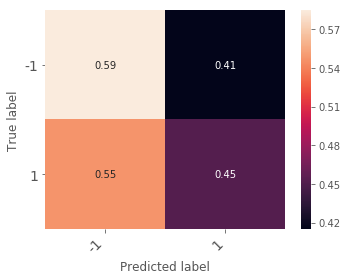

In [76]:
data = data_2_class.copy()

model = naive_bayes.MultinomialNB()

max_acc = 0
res = -1

for LIMIT in [0, 0.3, 0.5, 0.7]:
  X_train = create_feature_vector(data['Xtrain'], LIMIT, LIMIT)
  X_val = create_feature_vector(data['Xval'], LIMIT, LIMIT)
  
  model = model.fit(X=X_train, y=data['ytrain'])
  acc = metrics.accuracy_score(data['yval'], model.predict(X_val))
  print(acc)
  if acc > max_acc:
    max_acc = acc
    res = LIMIT

print('Train accuracy', max_acc)

X_train = create_feature_vector(data['Xtrain'], res, res)
model = model.fit(X=X_train, y=data['ytrain'])

X_tst = create_feature_vector(data['Xtst'], res, res)
predictions = model.predict(X_tst)

print('Evaluation')
print(metrics.accuracy_score(data['ytst'], predictions))
print(metrics.confusion_matrix(data['ytst'], predictions))
print_confusion_matrix(metrics.confusion_matrix(data['ytst'], predictions), ["-1", "1"])

#### 3 Class

In [0]:
data = data_3_class.copy()

model = naive_bayes.MultinomialNB()

max_acc = 0
res = -1

for posLIMIT in [0.03, 0.05, 0.0754, 0.097]:
  for negLIMIT in [-0.03, 0, 0.03, 0.058, 0.07]:
    if negLIMIT > posLIMIT:
      negLIMIT, posLIMIT = posLIMIT, negLIMIT

    X_train = create_feature_vector(data['Xtrain'], posLIMIT, negLIMIT)
    X_val = create_feature_vector(data['Xval'], posLIMIT, negLIMIT)

    model = model.fit(X=X_train, y=data['ytrain'])
    acc = metrics.accuracy_score(data['yval'], model.predict(X_val))
    if acc > max_acc:
      max_acc = acc
      res = (posLIMIT, negLIMIT)

print('Train accuracy', max_acc)

if res[1] > res[0]:
  res = (res[0], res[1])

X_train = create_feature_vector(data['Xtrain'], res[0], res[1])
model = model.fit(X=X_train, y=data['ytrain'])

X_tst = create_feature_vector(data['Xtst'], res[0], res[1])
predictions = model.predict(X_tst)

print('Evaluation')
print(metrics.accuracy_score(data['ytst'], predictions))
print(metrics.confusion_matrix(data['ytst'], predictions))
print_confusion_matrix(metrics.confusion_matrix(data['ytst'], predictions), ["-1", "0", "1"])

#### 2 Class

In [33]:
data = list(data2C)
# print(data2C[1][0])
vectoriser = CountVectorizer()
examples = vectoriser.fit_transform([u" ".join(x[0]) for x in data])
examples = hstack([examples, coo_matrix(create_feature_vector([" ".join(x[0]) for x in data], 0, 0))])

labels = [x[1] for x in data]
  
X_train, X_test, ytrain, ytest = train_test_split(examples, labels, train_size=0.8, shuffle=True, stratify=labels)
model = naive_bayes.MultinomialNB()


model = model.fit(X=X_train, y=ytrain)
y_pred = model.predict(X_test)

print(metrics.accuracy_score(ytrain, model.predict(X_train)))
print(metrics.accuracy_score(ytest, y_pred))

0.9977695167286246
0.7744807121661721


#### 3 Class

In [43]:
data = list(data3C)
# print(data2C[1][0])
vectoriser = CountVectorizer()
examples = vectoriser.fit_transform([u" ".join(x[0]) for x in data])
examples = hstack([examples, coo_matrix(create_feature_vector([" ".join(x[0]) for x in data], 0.01, 0.05))])

labels = [x[1] for x in data]
  
X_train, X_test, ytrain, ytest = train_test_split(examples, labels, train_size=0.65, shuffle=True, stratify=labels)
model = naive_bayes.MultinomialNB()


model = model.fit(X=X_train, y=ytrain)
y_pred = model.predict(X_test)

print(metrics.accuracy_score(ytrain, model.predict(X_train)))
print(metrics.accuracy_score(ytest, y_pred))

0.9975594874923734
0.5633484162895928


# Experiment 005

#### 2 Class

In [201]:
data = list(data2C)

EMBEDDING_DIM = 200

examples = [x[0] for x in data]

model = gensim.models.Word2Vec(sentences=examples, size=EMBEDDING_DIM, window=3, min_count=10, workers=2, iter=10)
words = list(model.wv.vocab)
print(len(words))
print(model.wv.most_similar('dobar'))

model.wv.save_word2vec_format('word2vec_2_class.txt')

6299
[(u'lo\u0161', 0.7990124225616455), (u'redak', 0.6578468084335327), (u'slab', 0.6495852470397949), (u'va\u017ean', 0.6244736313819885), (u'lep', 0.6136060953140259), (u'remek', 0.6055824160575867), (u'vrhunski', 0.5690031051635742), (u'pozitivan', 0.5637873411178589), (u'bitan', 0.5603445768356323), (u'genijalan', 0.5583980083465576)]


In [0]:
wordvectors = {}
with open('word2vec_2_class.txt') as f:
  vocab_size = int(f.readline().split()[0])
  
  for line in f:
    vals = line.split()
    wordvectors[vals[0]] = np.asarray(vals[1:], dtype=np.float)

In [203]:
data = data_2_class.copy()
tokenizer = Tokenizer()

all_examples = data['Xtrain'] + data['Xtst'] + data['Xval']
all_labels = list(map(lambda x: 0 if x == -1 else 1, data['ytrain'] + data['ytst'] + data['yval']))
tokenizer.fit_on_texts(all_examples)
seq = tokenizer.texts_to_sequences(all_examples)

longest_example = max([len(x.split()) for x in all_examples])
vocab_size = len(tokenizer.word_index) + 1

seq_padded = pad_sequences(seq, maxlen=longest_example)

print('Unique tokens', len(tokenizer.word_index))
print('padded', seq_padded.shape)
# model.fit([x[0] for x in data2C[:5]], [x[1] for x in data2C[:5]], verbose=2)

('Unique tokens', 47236)
('padded', (1682, 1831))


In [204]:
print(seq[0], all_labels[0])
print(model.wv.most_similar(tokenizer.index_word.items()[1127][1]))
print(data['Xtrain'][0])

([682, 1172, 1034, 1, 21, 16, 3023, 2, 11166, 301, 682, 60, 75, 3741, 700, 2568, 11167, 1, 2, 129, 463, 21, 16, 40, 171, 4, 623, 400, 1769, 9637, 2, 1222, 5, 24, 82, 48, 23185, 16759, 4, 301, 2339, 635, 11168, 1, 22, 1838, 157, 4, 36, 75, 6885, 2929, 11, 13, 163, 1074, 301, 488, 2, 1060, 23186, 679, 23187, 87, 1, 352, 75, 7614, 4, 394, 16760, 186, 336, 1075, 7615, 5, 13, 13382, 4, 53, 2, 400, 1770, 16761, 16, 1280, 75, 5, 1, 32, 152, 682, 1, 113, 7616, 91, 17, 2, 400, 9, 9637, 6, 47, 58, 14, 194, 3, 2110, 2169, 1337, 2, 460, 9, 94, 1, 460, 1280, 75, 1172, 1034, 48, 1487, 4, 425, 1, 612, 21, 45, 1362, 301, 1664, 173, 4, 110, 1, 124, 6, 26, 858, 23188, 2828, 2, 9638, 3148, 720, 7, 1172, 1034, 1809, 16762, 427, 415, 4095, 7617, 295, 6, 7618, 4, 3149, 1771, 1418, 2, 330, 6, 2220, 790, 1250, 943, 20, 257, 1, 9, 2, 1, 453, 208, 1281, 153, 150, 4095, 2170, 2, 4284, 3742, 4285, 4286, 233, 17, 104, 841, 3904, 926, 8489, 2, 1924, 480, 5, 1488, 4, 22, 1238, 1602, 4, 7, 18, 3429, 16, 295, 19, 1282

In [0]:
X_train = pad_sequences(tokenizer.texts_to_sequences(data['Xtrain']), maxlen=longest_example)
X_tst = pad_sequences(tokenizer.texts_to_sequences(data['Xtst']), maxlen=longest_example)
X_val = pad_sequences(tokenizer.texts_to_sequences(data['Xval']), maxlen=longest_example)

ytrain = to_categorical(list(map(lambda x: 0 if x == -1 else 1, data['ytrain'])))
ytst = to_categorical(list(map(lambda x: 0 if x == -1 else 1, data['ytst'])))
yval = to_categorical(list(map(lambda x: 0 if x == -1 else 1, data['yval'])))

In [206]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
  if i > vocab_size:
    continue
  embd = wordvectors.get(word)
  if embd is not None:
    embedding_matrix[i] = embd
    
print (np.shape(embedding_matrix))

(47237, 200)


In [209]:
model = Sequential()
embedding_layer = Embedding(vocab_size, EMBEDDING_DIM, embeddings_initializer=Constant(embedding_matrix), input_length=longest_example, trainable=False)
model.add(embedding_layer)
# model.add(CuDNNGRU(units=256))
# # model.add(Dense(1, activation='elu'))
# # model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
# model.add(Dropout(0.5))
# # model.add(Dense(250, activation='sigmoid'))
# model.add(Dense(1, activation='sigmoid'))

# model.add(Conv1D(8, 5, activation='relu'))
# model.add(MaxPool1D(5))
# model.add(Conv1D(32, 5, activation='relu'))
# model.add(Dropout(0.5))
# model.add(MaxPool1D(5))
# model.add(Conv1D(512, 5, activation='relu'))
# model.add(Dropout(0.5))
# model.add(MaxPool1D(20))

# model.add(Flatten())
model.add(Bidirectional(CuDNNLSTM(128)))
# model.add(Dense(1000, activation='relu'))
# model.add(Dense(200, activation='relu'))
model.add(Dense(2, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_73 (Embedding)     (None, 1831, 200)         9447400   
_________________________________________________________________
bidirectional_36 (Bidirectio (None, 256)               337920    
_________________________________________________________________
dense_115 (Dense)            (None, 2)                 514       
Total params: 9,785,834
Trainable params: 338,434
Non-trainable params: 9,447,400
_________________________________________________________________
None


In [0]:
with tf.device('/gpu:0'):
  model.fit(X_train, ytrain, validation_data=[X_val, yval], epochs=200, batch_size=128, verbose=1)

In [0]:
print(model.evaluate(X_tst, ytst))

#### 3 Class

In [177]:
data = list(data3C)

EMBEDDING_DIM = 200

examples = [x[0] for x in data]

model = gensim.models.Word2Vec(sentences=examples, size=EMBEDDING_DIM, window=5, min_count=5, workers=2, iter=10)
words = list(model.wv.vocab)
print(len(words))
print(model.wv.most_similar('dobar'))

model.wv.save_word2vec_format('word2vec_3_class.txt')

14438
[(u'lo\u0161', 0.7349477410316467), (u'redak', 0.6028866171836853), (u'solidan', 0.6008092761039734), (u'genijalan', 0.5859797596931458), (u'vrhunski', 0.5839639902114868), (u'sjajan', 0.561445415019989), (u'kvalitetan', 0.5511797666549683), (u'slab', 0.5476400852203369), (u'ok', 0.5466126799583435), (u'lep', 0.5232743620872498)]


In [0]:
wordvectors = {}
with open('word2vec_3_class.txt') as f:
  vocab_size = int(f.readline().split()[0])
  
  for line in f:
    vals = line.split()
    wordvectors[vals[0]] = np.asarray(vals[1:], dtype=np.float)

In [179]:
data = data_3_class.copy()
tokenizer = Tokenizer()

all_examples = data['Xtrain'] + data['Xtst'] + data['Xval']
all_labels = list(map(lambda x: 0 if x == -1 else 1, data['ytrain'] + data['ytst'] + data['yval']))
tokenizer.fit_on_texts(all_examples)
seq = tokenizer.texts_to_sequences(all_examples)

longest_example = max([len(x.split()) for x in all_examples])
vocab_size = len(tokenizer.word_index) + 1

seq_padded = pad_sequences(seq, maxlen=longest_example)

print('Unique tokens', len(tokenizer.word_index))
print('padded', seq_padded.shape)
# model.fit([x[0] for x in data2C[:5]], [x[1] for x in data2C[:5]], verbose=2)

('Unique tokens', 58435)
('padded', (2523, 1831))


In [180]:
print(seq[0], all_labels[0])
print(model.wv.most_similar(tokenizer.index_word.items()[1127][1]))
print(data['Xtrain'][0])

([57, 7, 1294, 4682, 28713, 65, 1063, 14424, 390, 138, 5, 938, 741, 9191, 28, 434, 28714, 2061, 7, 439, 28715, 8446, 21006, 72, 442, 17, 1582, 4, 14425, 41, 28716, 14426, 28717, 6, 1, 188, 37, 265, 136, 579, 320, 344, 84, 1, 44, 2, 78, 9192, 4, 4082, 2728, 443, 28718, 4, 17004, 7, 8447, 11, 17, 12572, 19, 124, 5, 98, 25, 33, 28, 970, 14427, 37, 225, 17, 2170, 19, 6, 28, 28719, 1999, 3836, 2134, 2, 445, 9, 9192, 15, 60, 50, 196, 4, 360, 827, 65, 124, 1, 1137, 15, 4508, 38, 6, 1, 3504, 445, 19, 6, 130, 4884, 63, 705, 172, 3, 3120, 23, 1482, 2, 3, 5, 2000, 4, 94, 9192, 1, 374, 7, 25, 396, 8, 36, 733, 55, 1, 14428, 663, 956, 2, 396, 19, 1295, 55, 1, 663, 711, 7, 2, 873, 110, 26, 53, 1, 410, 1900, 3, 28720, 2, 28721, 178, 1005, 4083, 121, 166, 36, 733, 846, 31, 1, 2, 12, 1, 231, 6452, 9192, 21007, 17005, 514, 8, 7, 28, 1968, 18, 1, 8, 23, 183, 207, 2847, 1, 87, 2671, 515, 11, 53, 107, 1718, 4, 415, 29, 25, 11179, 4, 6, 1, 21008, 1198, 15, 5299, 1869, 247, 3, 1, 2848, 46, 1583, 64, 1151, 16,

In [0]:
X_train = pad_sequences(tokenizer.texts_to_sequences(data['Xtrain']), maxlen=longest_example)
X_tst = pad_sequences(tokenizer.texts_to_sequences(data['Xtst']), maxlen=longest_example)
X_val = pad_sequences(tokenizer.texts_to_sequences(data['Xval']), maxlen=longest_example)

ytrain = to_categorical(data['ytrain'], num_classes=3)
ytst = to_categorical(data['ytst'], num_classes=3)
yval = to_categorical(data['yval'], num_classes=3)

In [0]:
print(np.unique(yval == [0, 0, 1], return_counts=True))
for i in yval:
  print(i)

In [197]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
  if i > vocab_size:
    continue
  embd = wordvectors.get(word)
  if embd is not None:
    embedding_matrix[i] = embd
    
print (np.shape(embedding_matrix))

(58436, 200)


In [0]:
model = Sequential()
embedding_layer = Embedding(vocab_size, EMBEDDING_DIM, embeddings_initializer=Constant(embedding_matrix), input_length=longest_example, trainable=False)
model.add(embedding_layer)
# model.add(CuDNNGRU(units=256))
# # model.add(Dense(1, activation='elu'))
# # model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
# model.add(Dropout(0.5))
# # model.add(Dense(250, activation='sigmoid'))
# model.add(Dense(1, activation='sigmoid'))

# model.add(Conv1D(8, 5, activation='relu'))
# model.add(MaxPool1D(5))
# model.add(Conv1D(32, 5, activation='relu'))
# model.add(Dropout(0.5))
# model.add(MaxPool1D(5))
# model.add(Conv1D(512, 5, activation='relu'))
# model.add(Dropout(0.5))
# model.add(MaxPool1D(20))

# model.add(Flatten())
model.add(CuDNNLSTM(128))
# model.add(Dense(1000, activation='relu'))
# model.add(Dense(200, activation='relu'))
model.add(Dense(3, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

In [0]:
with tf.device('/gpu:0'):
  model.fit(X_train, ytrain, validation_data=[X_val, yval], epochs=200, batch_size=128, verbose=1)

# Other